In [0]:
# install keras first
!pip install dill
!pip installqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq -q keras


In [0]:
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32"


In [0]:
from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_dim_ordering("th")

Using TensorFlow backend.


In [0]:
batch_size = 256
num_classes = 100
'''
epochs_longrun = 500
save_dir = "/work"
res_dir = "/results"
model_name = 'convnet_cifar100'
'''

'\nepochs_longrun = 500\nsave_dir = "/work"\nres_dir = "/results"\nmodel_name = \'convnet_cifar100\'\n'

In [0]:
from __future__ import print_function
import tensorflow as tf
import keras
from keras.datasets import cifar100
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.utils import to_categorical
from keras.models import load_model

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *
import warnings
warnings.filterwarnings('ignore')

In [0]:
tf.reset_default_graph()
tf.set_random_seed(343)
np.random.seed(343)
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()   # point!!!!
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 3, 32, 32)
50000 train samples
10000 test samples


In [0]:
# Convert class vectors to binary class matrices.
y_train_c = to_categorical(y_train, num_classes)
y_test_c = to_categorical(y_test, num_classes)
#Normalize data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0    
x_test /= 255.0

In [0]:
# Let's see what values are in the label y_train
np.unique(y_train)   # target is hundred classes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [0]:
coarse_label = [
'apple', # id 0
'aquarium_fish',
'baby',
'bear',
'beaver',
'bed',
'bee',
'beetle',
'bicycle',
'bottle',
'bowl',
'boy',
'bridge',
'bus',
'butterfly',
'camel',
'can',
'castle',
'caterpillar',
'cattle',
'chair',
'chimpanzee',
'clock',
'cloud',
'cockroach',
'couch',
'crab',
'crocodile',
'cup',
'dinosaur',
'dolphin',
'elephant',
'flatfish',
'forest',
'fox',
'girl',
'hamster',
'house',
'kangaroo',
'computer_keyboard',
'lamp',
'lawn_mower',
'leopard',
'lion',
'lizard',
'lobster',
'man',
'maple_tree',
'motorcycle',
'mountain',
'mouse',
'mushroom',
'oak_tree',
'orange',
'orchid',
'otter',
'palm_tree',
'pear',
'pickup_truck',
'pine_tree',
'plain',
'plate',
'poppy',
'porcupine',
'possum',
'rabbit',
'raccoon',
'ray',
'road',
'rocket',
'rose',
'sea',
'seal',
'shark',
'shrew',
'skunk',
'skyscraper',
'snail',
'snake',
'spider',
'squirrel',
'streetcar',
'sunflower',
'sweet_pepper',
'table',
'tank',
'telephone',
'television',
'tiger',
'tractor',
'train',
'trout',
'tulip',
'turtle',
'wardrobe',
'whale',
'willow_tree',
'wolf',
'woman',
'worm',
]

medium_sized_mammals_index = [ coarse_label.index(x) for x in ['fox', 'porcupine', 'possum', 'raccoon', 'skunk'] ]
small_mammals_index = [ coarse_label.index(x) for x in ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'] ]

medium_sized_remaining_mammals_index3 = [ coarse_label.index(x) for x in ['possum', 'porcupine','raccoon'] ]   ######
small_remaining_mammals_index3 = [ coarse_label.index(x) for x in ['mouse', 'hamster','rabbit'] ]  #######

medium_sized_rest_mammals_index3 = [ coarse_label.index(x) for x in ['skunk','fox'] ]   ###### new
small_rest_mammals_index3 = [ coarse_label.index(x) for x in ['shrew', 'squirrel'] ]  #######new

remaining_mammals_index = medium_sized_remaining_mammals_index3 + small_remaining_mammals_index3   ######
print (medium_sized_mammals_index, small_mammals_index, remaining_mammals_index)

[34, 63, 64, 66, 75] [36, 50, 65, 74, 80] [64, 63, 66, 50, 36, 65]


In [0]:
x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))

remaining_mammals_slice = np.array([ idx for idx, v in enumerate(y) if v[0] in remaining_mammals_index ])
rest_mammals_slice = np.array([ idx for idx, v in enumerate(y) if v[0] in (set(medium_sized_mammals_index) | set(small_mammals_index)) - set(remaining_mammals_index) ])

x_remaining_mammals = x[remaining_mammals_slice]
y_remaining_mammals = y[remaining_mammals_slice]
y_remaining_mammals_bin = np.array([ [int(y[0] in medium_sized_remaining_mammals_index3)] for y in y_remaining_mammals ])

# rest part for "not see animal "test
x_rest_mammals = x[rest_mammals_slice]
y_rest_mammals = y[rest_mammals_slice]
y_rest_mammals_bin = np.array([ [int(y[0] in medium_sized_rest_mammals_index3)] for y in y_rest_mammals ])  ####new
print(y_rest_mammals_bin)

print (x_remaining_mammals.shape, y_remaining_mammals.shape)
print (x_rest_mammals.shape, y_rest_mammals.shape)
print (y_remaining_mammals_bin.shape, y_rest_mammals_bin.shape)

from sklearn.model_selection import train_test_split

# the data will work on 
x_remaining_mammals_train, x_remaining_mammals_test, y_remaining_mammals_train, y_remaining_mammals_test = \
  train_test_split(x_remaining_mammals, y_remaining_mammals_bin, test_size=0.2, random_state=42)

print (x_remaining_mammals_train.shape, x_remaining_mammals_test.shape)
print (y_remaining_mammals_train.shape, y_remaining_mammals_test.shape)

[[0]
 [0]
 [1]
 ...
 [0]
 [0]
 [1]]
(3600, 3, 32, 32) (3600, 1)
(2400, 3, 32, 32) (2400, 1)
(3600, 1) (2400, 1)
(2880, 3, 32, 32) (720, 3, 32, 32)
(2880, 1) (720, 1)


In [0]:
# ten classes label
target_label = {34: 'fox', 63: 'porcupine', 64: 'possum', 66: 'raccoon', 75: 'skunk', 36: 'hamster', 50: 'mouse', 65: 'rabbit', 74: 'shrew', 80: 'squirrel'}

In [0]:
small_mammals = ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel']
medium_sized_mammals = ['fox', 'porcupine', 'possum', 'raccoon', 'skunk']

In [0]:
def cifar_grid2(X,Y,inds,n_col,predictions):  #print out randomly selected images and their labels  
  N = len(inds)
  n_row = int(ceil(1.0*N/n_col))
  fig = plt.figure(figsize=(15, 20))
  #count=0
  #l=list()
# align labels in the right order  #encode the target class
  clabels = ['small_mammals','medium_sized_mammal']
  #print(type(clabels))
  for j in range(n_row):
    for k in range(n_col):
      i_inds = (j*n_col)+k
      i_data = inds[i_inds]
     
      if i_inds < N:
        rgb = X[[i_data,...]]
        #test_label=test_list[0] if clabels[Y[i_data][0]]=='small_mammals' else test_list[1]  
        label =clabels[Y[i_data][0]]
        img = rgb.reshape(3,32,32).transpose([1, 2, 0])
        fig.add_subplot(n_row,n_col, i_inds+1)
        #pred = clabels[np.argmax(predictions[i_data,...])]
        pred = clabels[predictions[i_data]]
        plt.imshow(img, interpolation='nearest')
        plt.title("actual: {}\n predict: {}".format(label,pred))  
        #if label==pred:
        #  count+=1
        #  l.append(j*4+k)
  #print(count)
  #print(l)
         
  fig.set_tight_layout(True)

In [0]:
# choose 36 img randomly
indices = [np.random.choice(range(len(y_remaining_mammals_test))) for i in range(36)]
print (indices)



[625, 146, 108, 22, 150, 644, 294, 663, 65, 659, 497, 116, 563, 555, 218, 430, 125, 676, 330, 92, 114, 402, 39, 364, 152, 62, 491, 659, 691, 591, 563, 154, 164, 566, 281, 644]


# **Loop (CHING-MIN)**

In [0]:
# slect two from each superclass
def select_two(mammals_list):
  mammals_two=list()
  for i in range(0,5):
    for j in range(i+1,5):
      mammals_two.append([mammals_list[i],mammals_list[j]])
  return mammals_two

In [0]:
small_two=select_two(small_mammals)
medium_two=select_two(medium_sized_mammals)
#len(medium_two)

In [0]:
def train_test_2(small,medium): # test class for small and med
  small_mammals = ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel']
  small_mammals.remove(small[0])
  small_mammals.remove(small[1])
  medium_sized_mammals = ['fox', 'porcupine', 'possum', 'raccoon', 'skunk']
  medium_sized_mammals.remove(medium[0])
  medium_sized_mammals.remove(medium[1])
  
  # For training set
  medium_ind = [ coarse_label.index(x) for x in medium_sized_mammals ]
  small_ind = [ coarse_label.index(x) for x in small_mammals ]
  target_ind = medium_ind + small_ind

  #print ("Training set-\nNew index of Medium-sized mammals:", medium_ind,"\nNew index of Small mammals:", small_ind)

  # For testing data - 
  medium_ind_2 = [ coarse_label.index(x) for x in medium ]
  small_ind_2 = [ coarse_label.index(x) for x in small ]
  target_ind_2 = medium_ind_2 + small_ind_2
  #print ("\nTesting set-\nNew index of Medium-sized mammals:", medium_ind_2,"\nNew index of Small mammals:", small_ind_2)
  
  # Splice the dataset to extract the relevant portion of data
  train_slice3 = np.array([ idx for idx, y in enumerate(y) if y[0] in target_ind])
  y_train4 = y[train_slice3]
  x_train4 = x[train_slice3]

  # Test set
  test_slice3 = np.array([ idx for idx, y in enumerate(y) if y[0] in target_ind_2])
  y_test4 = y[test_slice3]
  x_test4 = x[test_slice3]

  print ("Training set:", np.unique(y_train4))
  print ("\nTesting set:", np.unique(y_test4))
  #  Binary as we are working with two superclasses labels (or coarse labels)
  y_train_bin4 = np.array([[int(y[0] in medium_ind)] for y in y_train4])
  y_test_bin4 = np.array([[int(y[0] in medium_ind_2)] for y in y_test4])
  y_bin4 = np.concatenate((y_train_bin4,y_test_bin4)) # for two superclass
  
  return x_train4,x_test4,y_train_bin4,y_test_bin4

In [0]:
# create list for train and test

x_train4=list()
x_test4=list()
y_train_bin4=list()
y_test_bin4=list()
test_list2=list()  
for i in range(0,10):
  for j in range(0,10):
    small=small_two[i]
    medium=medium_two[j]
    x_train_temp,x_test_temp,y_train_temp,y_test_temp=train_test_2(small,medium)
    x_train4.append(x_train_temp)
    x_test4.append(x_test_temp)
    y_train_bin4.append(y_train_temp)
    y_test_bin4.append(y_test_temp)
    test_list2.append([small,medium])  


Training set: [64 65 66 74 75 80]

Testing set: [34 36 50 63]
Training set: [63 65 66 74 75 80]

Testing set: [34 36 50 64]
Training set: [63 64 65 74 75 80]

Testing set: [34 36 50 66]
Training set: [63 64 65 66 74 80]

Testing set: [34 36 50 75]
Training set: [34 65 66 74 75 80]

Testing set: [36 50 63 64]
Training set: [34 64 65 74 75 80]

Testing set: [36 50 63 66]
Training set: [34 64 65 66 74 80]

Testing set: [36 50 63 75]
Training set: [34 63 65 74 75 80]

Testing set: [36 50 64 66]
Training set: [34 63 65 66 74 80]

Testing set: [36 50 64 75]
Training set: [34 63 64 65 74 80]

Testing set: [36 50 66 75]
Training set: [50 64 66 74 75 80]

Testing set: [34 36 63 65]
Training set: [50 63 66 74 75 80]

Testing set: [34 36 64 65]
Training set: [50 63 64 74 75 80]

Testing set: [34 36 65 66]
Training set: [50 63 64 66 74 80]

Testing set: [34 36 65 75]
Training set: [34 50 66 74 75 80]

Testing set: [36 63 64 65]
Training set: [34 50 64 74 75 80]

Testing set: [36 63 65 66]
Training

In [0]:
x_train4_ = [x_train4[i].reshape(x_train4[i].shape[0],3*32*32) for i in range(0,100)]
x_test4_ = [x_test4[i].reshape(x_test4[i].shape[0],3*32*32) for i in range(0,100)]
len(x_train4_)

100

100 trials:

x_train4_

x_test4_

y_train_bin4

y_test_bin4

In [0]:
from sklearn.ensemble import BaggingClassifier
start = time.time()
bag = BaggingClassifier()
bag.fit(x_train4_[0], y_train_bin4[0])
bag_pred=bag.predict(x_test4_[0])
print ("Accuracy ({}, {}): {}%".format(test_list2[0][0],test_list2[0][1] ,bag.score(x_test4_[0], y_test_bin4[0])*100)) 
end = time.time()"""

Accuracy (['hamster', 'mouse'], ['fox', 'porcupine']): 54.95833333333333%


# **Machine Learning Algorithms (Dandan and CHING-MIN)**

In [0]:
import time
#Let's see how good is RandomForest
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier, ExtraTreesClassifier,BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# reshape
x_remaining_mammals_train = x_remaining_mammals_train.reshape(x_remaining_mammals_train.shape[0],3*32*32)

x_remaining_mammals_test = x_remaining_mammals_test.reshape(x_remaining_mammals_test.shape[0],3*32*32)

x_rest_mammals = x_rest_mammals.reshape(x_rest_mammals.shape[0], 3*32*32)

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.model_selection import cross_val_score

In [0]:
# find the baseline performance for the random Forest
start = time.time()
logit = RandomForestClassifier()
logit.fit(x_remaining_mammals_train, y_remaining_mammals_train)
logit_pred=logit.predict(x_rest_mammals)
scores = cross_val_score(logit, x_remaining_mammals_train,y_remaining_mammals_train, cv=5)
print(scores)
print ("RandomForest Accuracy: {}%".format(logit.score(x_remaining_mammals_test, y_remaining_mammals_test)*100))
print ("RandomForest Accuracy: {}%".format(logit.score(x_rest_mammals, y_rest_mammals_bin)*100))
end = time.time()
print(end - start)

[0.6117851  0.63020833 0.67534722 0.68229167 0.67826087]
RandomForest Accuracy: 68.75%
RandomForest Accuracy: 50.916666666666664%
4.999434232711792


# **Random Forest with tuning the Parameters**

In [0]:
tuned_parameters = {'n_estimators': range(10,100,20), 'max_depth': range(2,20,5)}

In [0]:
%%time
logit = GridSearchCV(RandomForestClassifier(bootstrap = True), tuned_parameters, n_jobs = -1, cv=3, verbose=0)
logit.fit(x_remaining_mammals_train, y_remaining_mammals_train)

CPU times: user 8.47 s, sys: 120 ms, total: 8.6 s
Wall time: 1min 47s


In [0]:
print("Best parameters set found on development set:")
print()
print(logit.best_params_)
print()
print("Grid scores on development set:")
print()
means = logit.cv_results_['mean_test_score']
stds = logit.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, logit.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Best parameters set found on development set:

{'max_depth': 12, 'n_estimators': 90}

Grid scores on development set:

0.667 (+/-0.053) for {'max_depth': 2, 'n_estimators': 10}
0.671 (+/-0.053) for {'max_depth': 2, 'n_estimators': 30}
0.667 (+/-0.047) for {'max_depth': 2, 'n_estimators': 50}
0.670 (+/-0.049) for {'max_depth': 2, 'n_estimators': 70}
0.669 (+/-0.049) for {'max_depth': 2, 'n_estimators': 90}
0.655 (+/-0.015) for {'max_depth': 7, 'n_estimators': 10}
0.687 (+/-0.043) for {'max_depth': 7, 'n_estimators': 30}
0.686 (+/-0.034) for {'max_depth': 7, 'n_estimators': 50}
0.688 (+/-0.025) for {'max_depth': 7, 'n_estimators': 70}
0.692 (+/-0.045) for {'max_depth': 7, 'n_estimators': 90}
0.647 (+/-0.016) for {'max_depth': 12, 'n_estimators': 10}
0.686 (+/-0.049) for {'max_depth': 12, 'n_estimators': 30}
0.672 (+/-0.044) for {'max_depth': 12, 'n_estimators': 50}
0.689 (+/-0.040) for {'max_depth': 12, 'n_estimators': 70}
0.703 (+/-0.042) for {'max_depth': 12, 'n_estimators': 90}
0.651 

In [0]:
print ('prediction score on testing data with the best estimator: %.2f%%' % (logit.best_estimator_.score(x_remaining_mammals_test, y_remaining_mammals_test)*100))
print ('prediction score on testing data with the best estimator: %.2f%%' % (logit.best_estimator_.score(x_remaining_mammals_train, y_remaining_mammals_train)*100))
print ('prediction score on testing data with the best estimator: %.2f%%' % (logit.best_estimator_.score(x_rest_mammals, y_rest_mammals_bin)*100))

prediction score on testing data with the best estimator: 71.81%
prediction score on testing data with the best estimator: 99.83%
prediction score on testing data with the best estimator: 51.12%


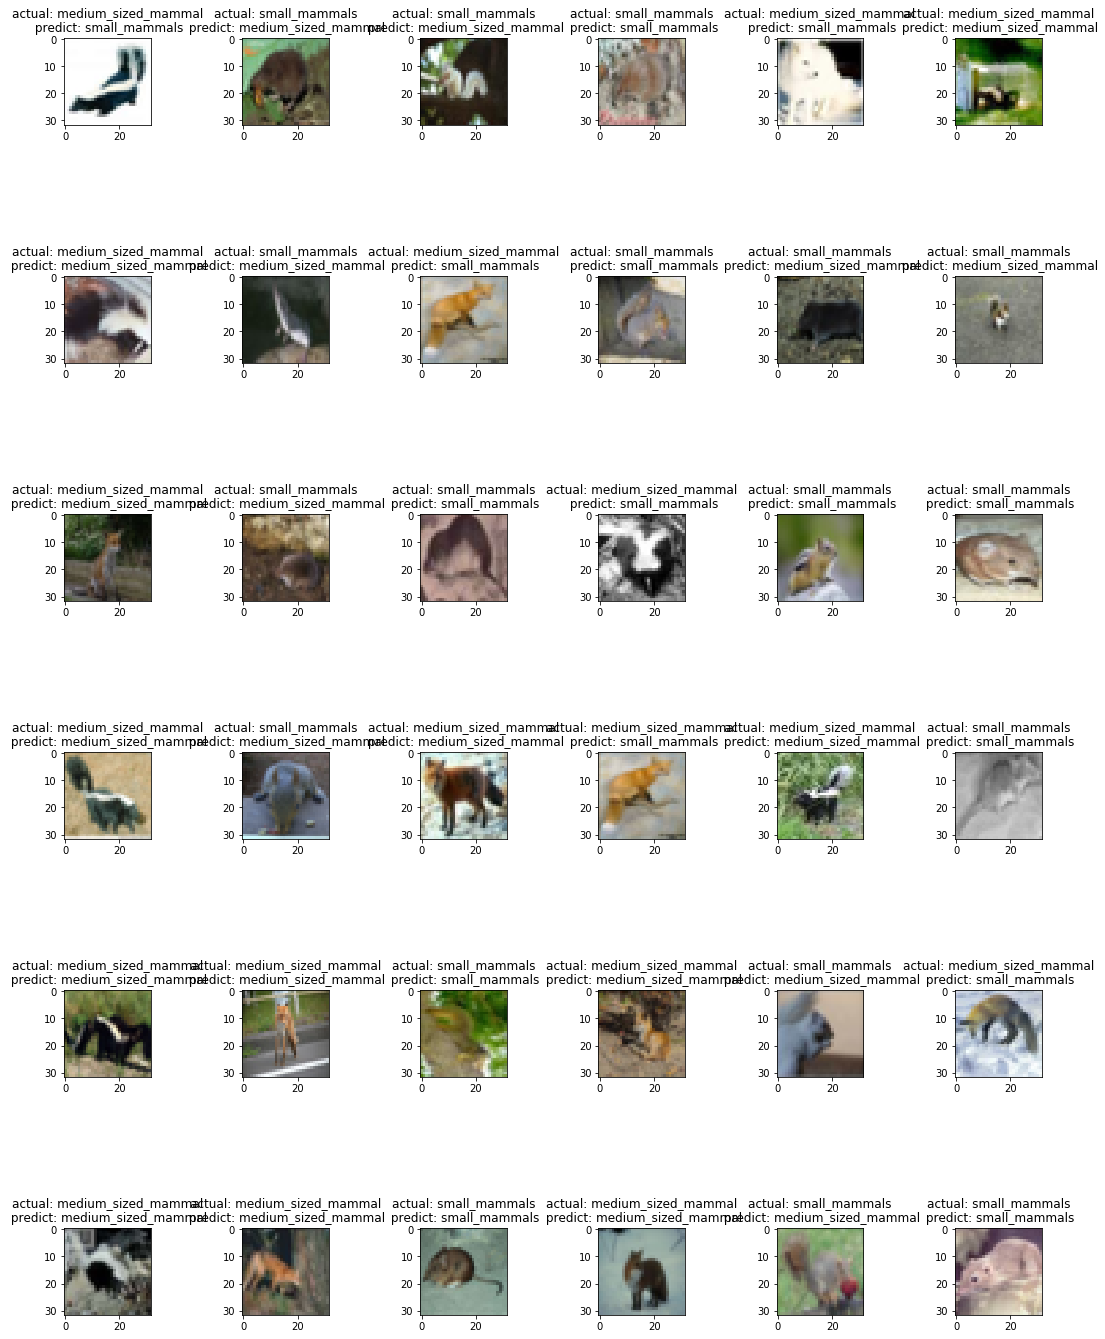

In [0]:
logit_pred=logit.predict(x_rest_mammals)
indices = [np.random.choice(range(len(x_rest_mammals))) for j in range(36)]
cifar_grid2(x_rest_mammals, y_rest_mammals_bin, indices,6,logit_pred)

In [0]:
print(confusion_matrix(y_rest_mammals_bin, logit_pred, labels=None, sample_weight=None))

[[477 723]
 [450 750]]


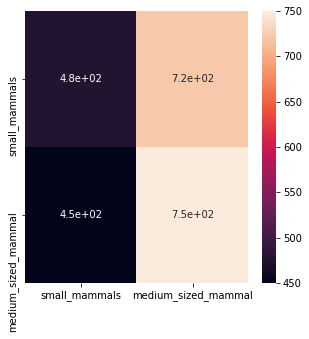

In [0]:
cm=confusion_matrix(y_rest_mammals_bin, logit_pred, labels=[0,1], sample_weight=None)
plt.figure(figsize = (5,5))
df_cm = pd.DataFrame(cm, index = [i for i in ['small_mammals','medium_sized_mammal']],
                  columns = [i for i in ['small_mammals','medium_sized_mammal']])

ax=sns.heatmap(df_cm, annot=True)

In [0]:
print (classification_report(y_rest_mammals_bin, logit_pred))

              precision    recall  f1-score   support

           0       0.51      0.40      0.45      1200
           1       0.51      0.62      0.56      1200

   micro avg       0.51      0.51      0.51      2400
   macro avg       0.51      0.51      0.50      2400
weighted avg       0.51      0.51      0.50      2400



# **Extra Decison Tree**

In [0]:
# train extra decision tree with default parameters
start = time.time()
Extratree = ExtraTreesClassifier()
Extratree.fit(x_remaining_mammals_train, y_remaining_mammals_train)
Extratree_pred=Extratree.predict(x_rest_mammals)
scores = cross_val_score(Extratree, x_remaining_mammals_train, y_remaining_mammals_train, cv=5)
print ("ExtraTree Accuracy: {}%".format(Extratree.score(x_remaining_mammals_test, y_remaining_mammals_test)*100))
print ("ExtraTree Accuracy: {}%".format(Extratree.score(x_rest_mammals, y_rest_mammals_bin)*100))
end = time.time()
print(end - start)

ExtraTree Accuracy: 66.38888888888889%
ExtraTree Accuracy: 51.125%
2.1861400604248047


In [0]:
tuned_parameters = {'n_estimators': range(10,100,20), 'max_depth': range(2,20,5)}

In [0]:
%%time
Extratree = GridSearchCV(ExtraTreesClassifier(bootstrap = True), tuned_parameters, cv=5, verbose=0)
Extratree.fit(x_remaining_mammals_train, y_remaining_mammals_train)

CPU times: user 1min 13s, sys: 190 µs, total: 1min 13s
Wall time: 1min 13s


In [0]:
print("Best parameters set found on development set:")
print()
print(Extratree.best_params_)
print()
print("Grid scores on development set:")
print()
means = Extratree.cv_results_['mean_test_score']
stds = Extratree.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, Extratree.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Best parameters set found on development set:

{'max_depth': 12, 'n_estimators': 70}

Grid scores on development set:

0.659 (+/-0.028) for {'max_depth': 2, 'n_estimators': 10}
0.660 (+/-0.058) for {'max_depth': 2, 'n_estimators': 30}
0.664 (+/-0.059) for {'max_depth': 2, 'n_estimators': 50}
0.673 (+/-0.046) for {'max_depth': 2, 'n_estimators': 70}
0.668 (+/-0.033) for {'max_depth': 2, 'n_estimators': 90}
0.665 (+/-0.025) for {'max_depth': 7, 'n_estimators': 10}
0.677 (+/-0.035) for {'max_depth': 7, 'n_estimators': 30}
0.678 (+/-0.056) for {'max_depth': 7, 'n_estimators': 50}
0.687 (+/-0.056) for {'max_depth': 7, 'n_estimators': 70}
0.680 (+/-0.043) for {'max_depth': 7, 'n_estimators': 90}
0.642 (+/-0.040) for {'max_depth': 12, 'n_estimators': 10}
0.676 (+/-0.039) for {'max_depth': 12, 'n_estimators': 30}
0.686 (+/-0.036) for {'max_depth': 12, 'n_estimators': 50}
0.691 (+/-0.043) for {'max_depth': 12, 'n_estimators': 70}
0.691 (+/-0.043) for {'max_depth': 12, 'n_estimators': 90}
0.648 

In [0]:
print ('prediction score on testing data with the best estimator: %.2f%%' % (Extratree.best_estimator_.score(x_remaining_mammals_test, y_remaining_mammals_test)*100))
print ('prediction score on testing data with the best estimator: %.2f%%' % (Extratree.best_estimator_.score(x_rest_mammals, y_rest_mammals_bin)*100))

prediction score on testing data with the best estimator: 71.67%
prediction score on testing data with the best estimator: 51.17%


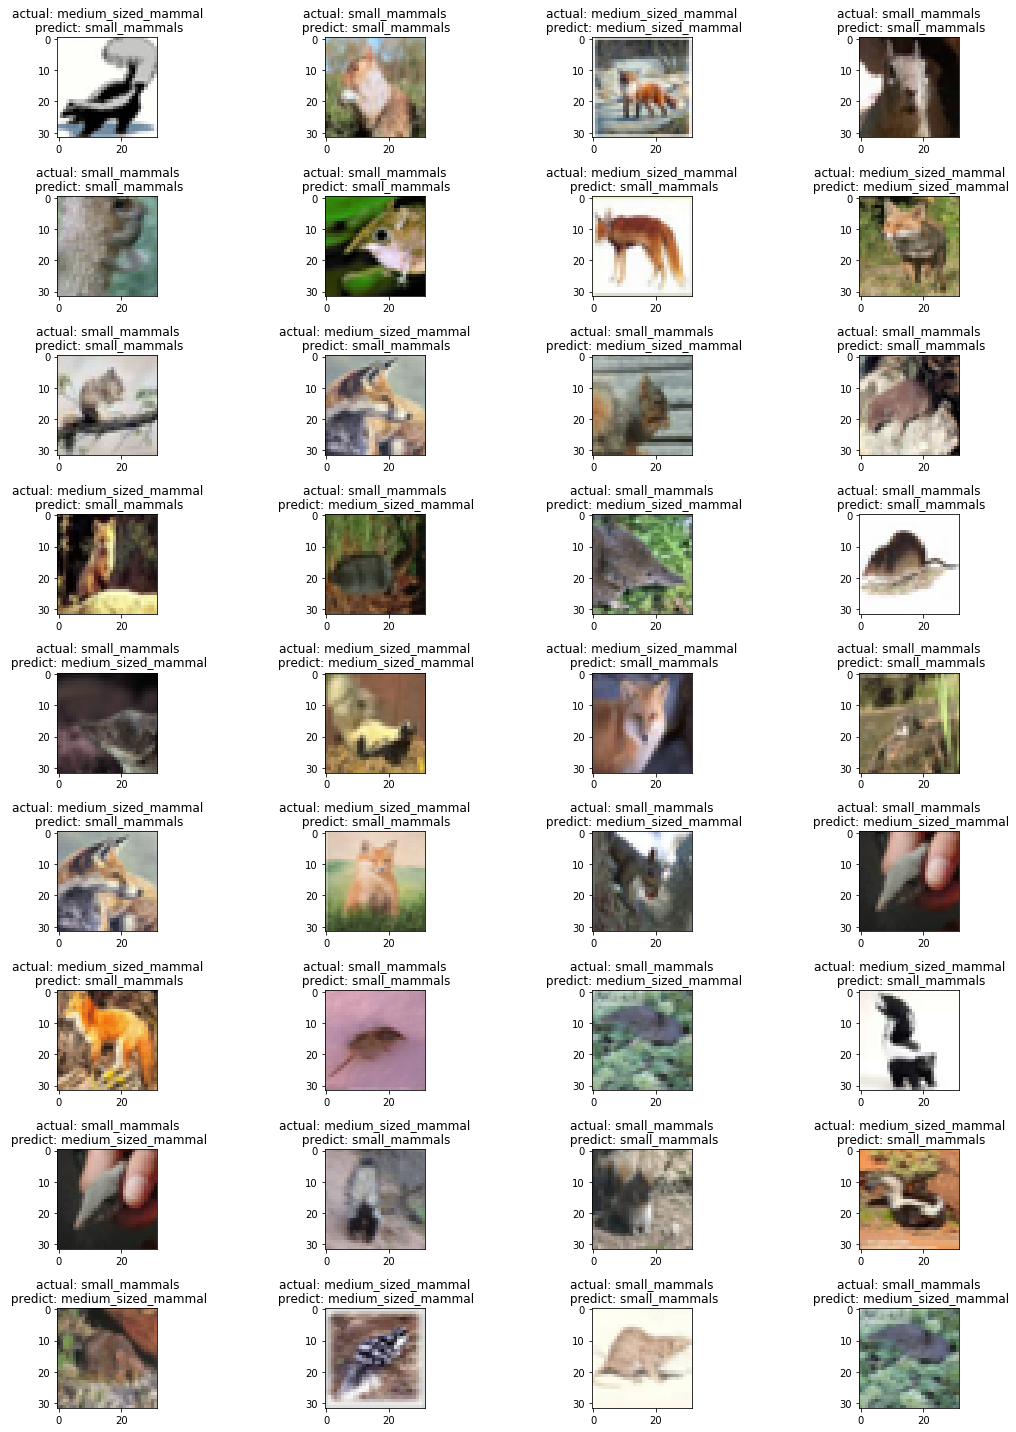

In [0]:
indices = [np.random.choice(range(len(x_rest_mammals))) for j in range(36)]
cifar_grid2(x_rest_mammals, y_rest_mammals_bin, indices,4,Extratree_pred)

In [0]:
print(confusion_matrix(y_rest_mammals_bin, Extratree_pred, labels=None, sample_weight=None))

[[644 556]
 [617 583]]


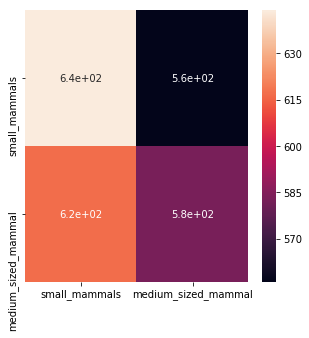

In [0]:
cm=confusion_matrix(y_rest_mammals_bin, Extratree_pred, labels=[0,1], sample_weight=None)
plt.figure(figsize = (5,5))
df_cm = pd.DataFrame(cm, index = [i for i in ['small_mammals','medium_sized_mammal']],
                  columns = [i for i in ['small_mammals','medium_sized_mammal']])

ax=sns.heatmap(df_cm, annot=True)

In [0]:
print (classification_report(y_rest_mammals_bin, Extratree_pred))

              precision    recall  f1-score   support

           0       0.51      0.54      0.52      1200
           1       0.51      0.49      0.50      1200

   micro avg       0.51      0.51      0.51      2400
   macro avg       0.51      0.51      0.51      2400
weighted avg       0.51      0.51      0.51      2400



# **KNN**

## **find the best peremeter**

In [0]:
# find the baseline performance for the bagging
start = time.time()
knn = KNeighborsClassifier()
knn.fit(x_remaining_mammals, y_remaining_mammals_bin)
knn_pred=knn.predict(x_rest_mammals)
scores = cross_val_score(knn, x_remaining_mammals,y_remaining_mammals_bin, cv=5)
print(scores)
scores = cross_val_score(knn, x_rest_mammals,y_rest_mammals_bin, cv=5)
print(scores)
print ("KNN Accuracy: {}%".format(knn.score(x_remaining_mammals, y_remaining_mammals_bin)*100))
print ("KNN Accuracy: {}%".format(knn.score(x_rest_mammals, y_rest_mammals_bin)*100))
end = time.time()
print(end - start)

[0.63194444 0.66666667 0.61527778 0.66388889 0.65833333]
[1. 1. 1. 1. 1.]
KNN Accuracy: 77.30555555555556%
KNN Accuracy: 54.45833333333333%
330.22875595092773


In [0]:
for a in [1,2,3]:
  for b in ['uniform','distance']:
    print('n_neighbors: {}, weights: {}'.format(a,b))
    knn_clf = KNeighborsClassifier(n_neighbors=a, weights=b)
    knn_clf.fit(x_remaining_mammals, y_remaining_mammals_bin)
    scores = cross_val_score(knn_clf, x_remaining_mammals,y_remaining_mammals, cv=5)
    print(scores)
    print ("KNN Accuracy: {}%\n".format(knn_clf.score(x_rest_mammals, y_rest_mammals_bin)*100))

n_neighbors: 1, weights: uniform
[0.34861111 0.38472222 0.33611111 0.34861111 0.34305556]
KNN Accuracy: 49.583333333333336%

n_neighbors: 1, weights: distance
[0.34861111 0.38472222 0.33611111 0.34861111 0.34305556]
KNN Accuracy: 49.583333333333336%

n_neighbors: 2, weights: uniform
[0.3375     0.36944444 0.34027778 0.35416667 0.33194444]
KNN Accuracy: 50.125%

n_neighbors: 2, weights: distance
[0.34861111 0.38472222 0.33611111 0.34861111 0.34305556]
KNN Accuracy: 49.583333333333336%

n_neighbors: 3, weights: uniform
[0.31388889 0.35555556 0.34444444 0.34444444 0.35138889]
KNN Accuracy: 50.66666666666667%

n_neighbors: 3, weights: distance
[0.33194444 0.38333333 0.34444444 0.35277778 0.34861111]
KNN Accuracy: 50.625%



In [0]:
for a in [4,5,6]:
  for b in ['uniform','distance']:
    print('n_neighbors: {}, weights: {}'.format(a,b))
    knn_clf = KNeighborsClassifier(n_neighbors=a, weights=b)
    knn_clf.fit(x_remaining_mammals, y_remaining_mammals_bin)
    scores = cross_val_score(knn_clf, x_remaining_mammals,y_remaining_mammals, cv=5)
    print(scores)
    print ("KNN Accuracy: {}%\n".format(knn_clf.score(x_rest_mammals, y_rest_mammals_bin)*100))

n_neighbors: 4, weights: uniform
[0.33333333 0.38194444 0.34444444 0.36388889 0.34722222]
KNN Accuracy: 51.66666666666667%

n_neighbors: 4, weights: distance
[0.33472222 0.39583333 0.34166667 0.35972222 0.36388889]
KNN Accuracy: 50.916666666666664%

n_neighbors: 5, weights: uniform
[0.33472222 0.38472222 0.34444444 0.35972222 0.34861111]
KNN Accuracy: 51.29166666666667%

n_neighbors: 5, weights: distance
[0.33888889 0.40416667 0.34305556 0.35416667 0.35      ]
KNN Accuracy: 51.24999999999999%

n_neighbors: 6, weights: uniform
[0.34305556 0.37361111 0.33888889 0.34583333 0.35      ]
KNN Accuracy: 51.45833333333333%

n_neighbors: 6, weights: distance
[0.35277778 0.41111111 0.34861111 0.35555556 0.35694444]
KNN Accuracy: 51.74999999999999%



In [0]:
for a in [7,8,9]:
  for b in ['uniform','distance']:
    print('n_neighbors: {}, weights: {}'.format(a,b))
    knn_clf = KNeighborsClassifier(n_neighbors=a, weights=b)
    knn_clf.fit(x_remaining_mammals, y_remaining_mammals_bin)
    scores = cross_val_score(knn_clf, x_remaining_mammals,y_remaining_mammals, cv=5)
    print(scores)
    print ("KNN Accuracy: {}%\n".format(knn_clf.score(x_rest_mammals, y_rest_mammals_bin)*100))

n_neighbors: 7, weights: uniform
[0.34027778 0.38055556 0.34027778 0.34305556 0.33333333]
KNN Accuracy: 52.666666666666664%

n_neighbors: 7, weights: distance
[0.34166667 0.39444444 0.35       0.35555556 0.35277778]
KNN Accuracy: 52.625%

n_neighbors: 8, weights: uniform
[0.34305556 0.38333333 0.34166667 0.35       0.34444444]
KNN Accuracy: 52.208333333333336%

n_neighbors: 8, weights: distance
[0.34166667 0.39722222 0.35138889 0.35694444 0.35972222]
KNN Accuracy: 52.625%

n_neighbors: 9, weights: uniform
[0.35277778 0.38472222 0.33055556 0.35555556 0.32777778]
KNN Accuracy: 52.37500000000001%

n_neighbors: 9, weights: distance
[0.34305556 0.40416667 0.34583333 0.3625     0.33194444]
KNN Accuracy: 52.37500000000001%



In [0]:
for a in [10,20,50]:
  for b in ['uniform','distance']:
    print('n_neighbors: {}, weights: {}'.format(a,b))
    knn_clf = KNeighborsClassifier(n_neighbors=a, weights=b)
    knn_clf.fit(x_remaining_mammals, y_remaining_mammals_bin)
    scores = cross_val_score(knn_clf, x_remaining_mammals,y_remaining_mammals, cv=5)
    print(scores)
    print ("KNN Accuracy: {}%\n".format(knn_clf.score(x_rest_mammals, y_rest_mammals_bin)*100))

n_neighbors: 10, weights: uniform
[0.34305556 0.38055556 0.32638889 0.35694444 0.32916667]
KNN Accuracy: 51.95833333333333%

n_neighbors: 10, weights: distance
[0.34305556 0.4        0.34166667 0.36805556 0.33194444]
KNN Accuracy: 52.166666666666664%

n_neighbors: 20, weights: uniform
[0.35       0.37638889 0.31388889 0.35138889 0.34444444]
KNN Accuracy: 52.166666666666664%

n_neighbors: 20, weights: distance
[0.35416667 0.38194444 0.325      0.34722222 0.34027778]
KNN Accuracy: 52.5%

n_neighbors: 50, weights: uniform
[0.32777778 0.34722222 0.32083333 0.34305556 0.32777778]
KNN Accuracy: 53.29166666666667%

n_neighbors: 50, weights: distance
[0.33333333 0.35416667 0.31944444 0.34722222 0.3375    ]
KNN Accuracy: 53.125%



In [0]:
for a in [100,200,500,1000]:
  for b in ['uniform','distance']:
    print('n_neighbors: {}, weights: {}'.format(a,b))
    knn_clf = KNeighborsClassifier(n_neighbors=a, weights=b)
    knn_clf.fit(x_remaining_mammals, y_remaining_mammals_bin)
    scores = cross_val_score(knn_clf, x_remaining_mammals,y_remaining_mammals, cv=5)
    print(scores)
    print ("KNN Accuracy: {}%\n".format(knn_clf.score(x_rest_mammals, y_rest_mammals_bin)*100))

n_neighbors: 100, weights: uniform
[0.31527778 0.34722222 0.325      0.34166667 0.31388889]
KNN Accuracy: 54.083333333333336%

n_neighbors: 100, weights: distance
[0.32083333 0.35       0.32638889 0.34027778 0.32638889]
KNN Accuracy: 54.166666666666664%

n_neighbors: 200, weights: uniform
[0.30416667 0.33333333 0.32638889 0.3125     0.29861111]
KNN Accuracy: 54.125%

n_neighbors: 200, weights: distance
[0.30972222 0.34583333 0.32083333 0.31527778 0.29861111]
KNN Accuracy: 54.166666666666664%

n_neighbors: 500, weights: uniform
[0.29166667 0.28194444 0.31666667 0.28333333 0.2875    ]
KNN Accuracy: 52.0%

n_neighbors: 500, weights: distance
[0.29861111 0.29027778 0.325      0.29444444 0.28888889]
KNN Accuracy: 52.125%

n_neighbors: 1000, weights: uniform
[0.30138889 0.27083333 0.31666667 0.28888889 0.27083333]
KNN Accuracy: 51.37500000000001%

n_neighbors: 1000, weights: distance
[0.29861111 0.28194444 0.31805556 0.28194444 0.27777778]
KNN Accuracy: 51.541666666666664%



## **train by the best peremeter**

the best peremeter: n_neighbors=100,weights='distance'

In [0]:
start = time.time()
knn = KNeighborsClassifier(n_neighbors=100,weights='distance')
knn.fit(x_remaining_mammals, y_remaining_mammals_bin)
knn_pred=knn.predict(x_rest_mammals)
#scores = cross_val_score(knn, x_remaining_mammals,y_remaining_mammals_bin, cv=5)
#print(scores)
#scores = cross_val_score(knn, x_rest_mammals,y_rest_mammals_bin, cv=5)
#print(scores)
print ("KNN Accuracy: {}%".format(knn.score(x_remaining_mammals, y_remaining_mammals_bin)*100))
print ("KNN Accuracy: {}%".format(knn.score(x_rest_mammals, y_rest_mammals_bin)*100))
end = time.time()
print(end - start)

KNN Accuracy: 100.0%
KNN Accuracy: 54.166666666666664%
220.13702368736267


In [0]:
indices = [np.random.choice(range(len(x_rest_mammals))) for i in range(36)]

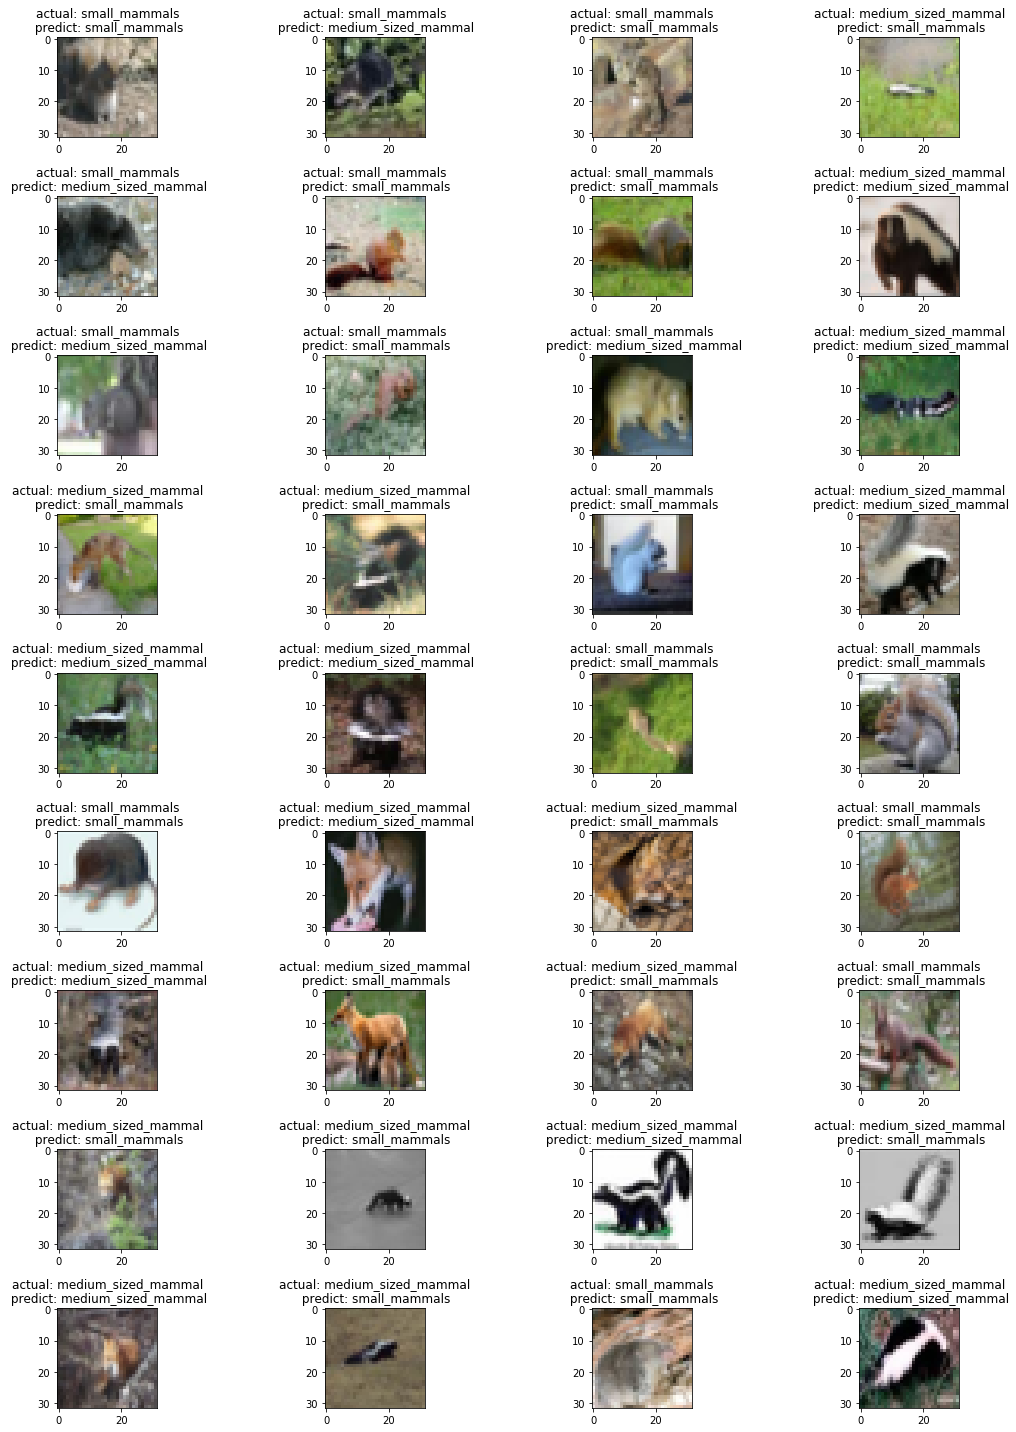

In [0]:
cifar_grid2(x_rest_mammals,y_rest_mammals_bin,indices,4,knn_pred)

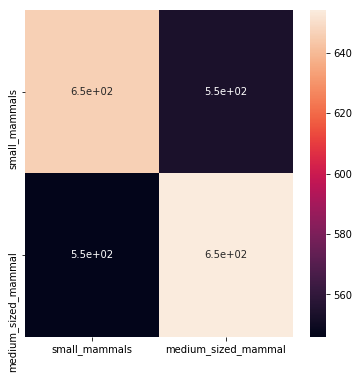

In [0]:
cm=confusion_matrix(y_rest_mammals_bin, knn_pred, labels=[0,1], sample_weight=None)
plt.figure(figsize = (6,6))
df_cm = pd.DataFrame(cm, index = [i for i in ['small_mammals','medium_sized_mammal']],
                  columns = [i for i in ['small_mammals','medium_sized_mammal']])

ax=sns.heatmap(df_cm, annot=True)

In [0]:
print(classification_report(y_rest_mammals_bin, knn_pred,target_names=['small_mammals','medium_sized_mammal']))

                     precision    recall  f1-score   support

      small_mammals       0.54      0.54      0.54      1200
medium_sized_mammal       0.54      0.55      0.54      1200

          micro avg       0.54      0.54      0.54      2400
          macro avg       0.54      0.54      0.54      2400
       weighted avg       0.54      0.54      0.54      2400



## **100 trials by the best peremeter**

In [0]:
knn_accuracy2=list()
knn_time2=list()
print("KNN ") 
for i in range(0,100):
  start = time.time()
  knn1 = KNeighborsClassifier(n_neighbors=100, weights='distance')
  knn1.fit(x_train4_[i], y_train_bin4[i])
  #knn1_pred=knn1.predict(x_test4_[i])
  print ("Accuracy ({}, {}): {}%".format(test_list2[i][0],test_list2[i][1] ,knn1.score(x_test4_[i], y_test_bin4[i])*100)) 
  end = time.time()
  print('{} seconds'.format(end - start))
  knn_accuracy2.append(knn1.score(x_test4_[i], y_test_bin4[i]))
  knn_time2.append(end-start)
  # choose 36 img randomly
  #indices = [np.random.choice(range(len(x_test3_[i]))) for j in range(36)]
  #cifar_grid1(x_test3_[i], y_test_bin3[i], indices,4,lr_pred)
print("average accuracy: {}%".format(np.mean(knn_accuracy2)*100))
print("average time: {} seconds".format(np.mean(knn_time2)))

KNN 
Accuracy (['hamster', 'mouse'], ['fox', 'porcupine']): 52.125%
53.68342614173889 seconds
Accuracy (['hamster', 'mouse'], ['fox', 'possum']): 55.708333333333336%
53.76803135871887 seconds
Accuracy (['hamster', 'mouse'], ['fox', 'raccoon']): 52.83333333333333%
53.62080669403076 seconds
Accuracy (['hamster', 'mouse'], ['fox', 'skunk']): 52.33333333333333%
53.68988370895386 seconds
Accuracy (['hamster', 'mouse'], ['porcupine', 'possum']): 54.29166666666667%
53.824082374572754 seconds
Accuracy (['hamster', 'mouse'], ['porcupine', 'raccoon']): 50.541666666666664%
53.64753437042236 seconds
Accuracy (['hamster', 'mouse'], ['porcupine', 'skunk']): 51.583333333333336%
53.781091928482056 seconds
Accuracy (['hamster', 'mouse'], ['possum', 'raccoon']): 55.166666666666664%
54.30186581611633 seconds
Accuracy (['hamster', 'mouse'], ['possum', 'skunk']): 54.95833333333333%
53.812493085861206 seconds
Accuracy (['hamster', 'mouse'], ['raccoon', 'skunk']): 50.583333333333336%
53.99618220329285 second

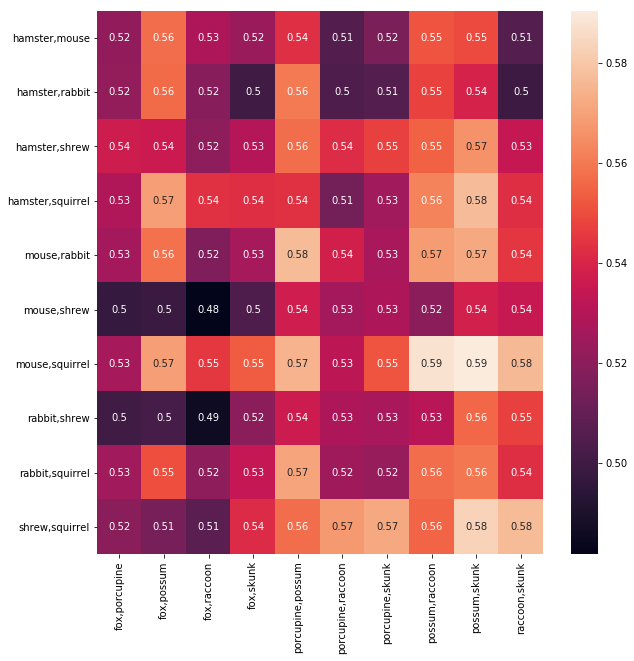

In [0]:
#cm=confusion_matrix(y_test_bin_1, bag_pred, labels=[0,1], sample_weight=None)
plt.figure(figsize = (10,10))
data=pd.DataFrame([knn_accuracy2[0:10],knn_accuracy2[10:20],knn_accuracy2[20:30],knn_accuracy2[30:40],knn_accuracy2[40:50],knn_accuracy2[50:60],knn_accuracy2[60:70],knn_accuracy2[70:80],knn_accuracy2[80:90],knn_accuracy2[90:100]],
                  index = [small_two[i][0]+','+small_two[i][1] for i in range(0,10)],
                  columns = [medium_two[i][0]+','+medium_two[i][1] for i in range(0,10)])


ax=sns.heatmap(data, annot=True)

In [0]:
pd.DataFrame(knn_accuracy2,columns=['KNN 2 pair missing']).describe()

,KNN 2 pair missing
count,100.000000
mean,0.537883
std,0.023932
min,0.481667
25%,0.521562
50%,0.536875
75%,0.556042
max,0.590417


# **Bagging**

In [0]:
# find the baseline performance for the bagging
start = time.time()
bag = BaggingClassifier()
bag.fit(x_remaining_mammals, y_remaining_mammals_bin)
bag_pred=bag.predict(x_rest_mammals)
scores = cross_val_score(bag, x_remaining_mammals,y_remaining_mammals_bin, cv=5)
print(scores)
scores = cross_val_score(bag, x_rest_mammals,y_rest_mammals_bin, cv=5)
print(scores)
print ("Bagging Accuracy: {}%".format(bag.score(x_remaining_mammals, y_remaining_mammals_bin)*100))
print ("Bagging Accuracy: {}%".format(bag.score(x_rest_mammals, y_rest_mammals_bin)*100))
end = time.time()
print(end - start)

[0.70416667 0.70625    0.75       0.70625    0.69166667]
[0.6375     0.64861111 0.6625     0.64027778 0.64444444]
Bagging Accuracy: 99.0%
Bagging Accuracy: 50.16666666666667%
557.3837399482727


## **find the best peremeter**

In [0]:
for a in [1,2,3]:
  for b in [0.001,0.01]:
    for c in [True,False]:
      for d in [True,False]:
        print('n_estimators: {}, max_sample: {}, bootstrap: {}, bootstrap_features: {}'.format(a,b,c,d))
        bag_clf = BaggingClassifier(n_estimators=a, max_samples=b, bootstrap=c, bootstrap_features=d)
        bag_clf.fit(x_remaining_mammals, y_remaining_mammals_bin)
        scores = cross_val_score(bag_clf, x_remaining_mammals,y_remaining_mammals_bin, cv=5)
        print(scores)
        print ("Bagging Accuracy: {}%".format(bag_clf.score(x_rest_mammals, y_rest_mammals_bin)*100))

n_estimators: 1, max_sample: 0.001, bootstrap: True, bootstrap_features: True
[0.5 0.5 0.5 0.5 0.5]
Bagging Accuracy: 47.77777777777778%
n_estimators: 1, max_sample: 0.001, bootstrap: True, bootstrap_features: False
[0.5 0.5 0.5 0.5 0.5]
Bagging Accuracy: 47.44444444444444%
n_estimators: 1, max_sample: 0.001, bootstrap: False, bootstrap_features: True
[0.5 0.5 0.5 0.5 0.5]
Bagging Accuracy: 51.47222222222222%
n_estimators: 1, max_sample: 0.001, bootstrap: False, bootstrap_features: False
[0.5 0.5 0.5 0.5 0.5]
Bagging Accuracy: 49.083333333333336%
n_estimators: 1, max_sample: 0.01, bootstrap: True, bootstrap_features: True
[0.6125     0.64583333 0.60416667 0.55833333 0.5125    ]
Bagging Accuracy: 52.94444444444445%
n_estimators: 1, max_sample: 0.01, bootstrap: True, bootstrap_features: False
[0.55833333 0.57083333 0.61666667 0.58333333 0.57708333]
Bagging Accuracy: 48.583333333333336%
n_estimators: 1, max_sample: 0.01, bootstrap: False, bootstrap_features: True
[0.46666667 0.55       0.

In [0]:
for a in [4,5,10]:
  for b in [0.001,0.01]:
    for c in [True,False]:
      for d in [True,False]:
        print('n_estimators: {}, max_sample: {}, bootstrap: {}, bootstrap_features: {}'.format(a,b,c,d))
        bag_clf = BaggingClassifier(n_estimators=a, max_samples=b, bootstrap=c, bootstrap_features=d)
        bag_clf.fit(x_remaining_mammals, y_remaining_mammals_bin)
        scores = cross_val_score(bag_clf, x_remaining_mammals,y_remaining_mammals_bin, cv=5)
        print(scores)
        print ("Bagging Accuracy: {}%".format(bag_clf.score(x_rest_mammals, y_rest_mammals_bin)*100))

n_estimators: 4, max_sample: 0.001, bootstrap: True, bootstrap_features: True
[0.5 0.5 0.5 0.5 0.5]
Bagging Accuracy: 49.25%
n_estimators: 4, max_sample: 0.001, bootstrap: True, bootstrap_features: False
[0.5 0.5 0.5 0.5 0.5]
Bagging Accuracy: 50.74999999999999%
n_estimators: 4, max_sample: 0.001, bootstrap: False, bootstrap_features: True
[0.5 0.5 0.5 0.5 0.5]
Bagging Accuracy: 49.69444444444445%
n_estimators: 4, max_sample: 0.001, bootstrap: False, bootstrap_features: False
[0.5 0.5 0.5 0.5 0.5]
Bagging Accuracy: 53.333333333333336%
n_estimators: 4, max_sample: 0.01, bootstrap: True, bootstrap_features: True
[0.61458333 0.62083333 0.64166667 0.63958333 0.55625   ]
Bagging Accuracy: 48.91666666666667%
n_estimators: 4, max_sample: 0.01, bootstrap: True, bootstrap_features: False
[0.6625     0.59791667 0.63125    0.63333333 0.6375    ]
Bagging Accuracy: 50.94444444444445%
n_estimators: 4, max_sample: 0.01, bootstrap: False, bootstrap_features: True
[0.59791667 0.56041667 0.67708333 0.63

In [0]:
for a in [100,500,1000]:
  for b in [0.001,0.01]:
    for c in [True,False]:
      for d in [True,False]:
        print('n_estimators: {}, max_sample: {}, bootstrap: {}, bootstrap_features: {}'.format(a,b,c,d))
        bag_clf = BaggingClassifier(n_estimators=a, max_samples=b, bootstrap=c, bootstrap_features=d)
        bag_clf.fit(x_remaining_mammals, y_remaining_mammals_bin)
        scores = cross_val_score(bag_clf, x_remaining_mammals,y_remaining_mammals_bin, cv=5)
        print(scores)
        print ("Bagging Accuracy: {}%".format(bag_clf.score(x_rest_mammals, y_rest_mammals_bin)*100))

n_estimators: 100, max_sample: 0.001, bootstrap: True, bootstrap_features: True
[0.5 0.5 0.5 0.5 0.5]
Bagging Accuracy: 52.47222222222222%
n_estimators: 100, max_sample: 0.001, bootstrap: True, bootstrap_features: False
[0.5 0.5 0.5 0.5 0.5]
Bagging Accuracy: 50.05555555555555%
n_estimators: 100, max_sample: 0.001, bootstrap: False, bootstrap_features: True
[0.5 0.5 0.5 0.5 0.5]
Bagging Accuracy: 50.027777777777786%
n_estimators: 100, max_sample: 0.001, bootstrap: False, bootstrap_features: False
[0.5 0.5 0.5 0.5 0.5]
Bagging Accuracy: 50.55555555555556%
n_estimators: 100, max_sample: 0.01, bootstrap: True, bootstrap_features: True
[0.69583333 0.70208333 0.70833333 0.71041667 0.69166667]
Bagging Accuracy: 53.61111111111111%
n_estimators: 100, max_sample: 0.01, bootstrap: True, bootstrap_features: False
[0.68333333 0.70625    0.7        0.72916667 0.70208333]
Bagging Accuracy: 53.27777777777778%
n_estimators: 100, max_sample: 0.01, bootstrap: False, bootstrap_features: True
[0.69375    

In [0]:
for a in [1,10,100]:
  for b in [0.1,1]:
    for c in [True,False]:
      for d in [True,False]:
        print('n_estimators: {}, max_sample: {}, bootstrap: {}, bootstrap_features: {}'.format(a,b,c,d))
        bag_clf = BaggingClassifier(n_estimators=a, max_samples=b, bootstrap=c, bootstrap_features=d)
        bag_clf.fit(x_remaining_mammals, y_remaining_mammals_bin)
        scores = cross_val_score(bag_clf, x_remaining_mammals,y_remaining_mammals_bin, cv=5)
        print(scores)
        print ("Bagging Accuracy: {}%".format(bag_clf.score(x_rest_mammals, y_rest_mammals_bin)*100))

n_estimators: 1, max_sample: 0.1, bootstrap: True, bootstrap_features: True
[0.62708333 0.60833333 0.575      0.60833333 0.57916667]
Bagging Accuracy: 48.66666666666667%
n_estimators: 1, max_sample: 0.1, bootstrap: True, bootstrap_features: False
[0.61041667 0.59791667 0.63333333 0.61041667 0.66458333]
Bagging Accuracy: 49.888888888888886%
n_estimators: 1, max_sample: 0.1, bootstrap: False, bootstrap_features: True
[0.54583333 0.61666667 0.63125    0.58958333 0.58541667]
Bagging Accuracy: 47.27777777777778%
n_estimators: 1, max_sample: 0.1, bootstrap: False, bootstrap_features: False
[0.61041667 0.59375    0.64583333 0.6        0.625     ]
Bagging Accuracy: 51.63888888888889%
n_estimators: 1, max_sample: 1, bootstrap: True, bootstrap_features: True
[0.5 0.5 0.5 0.5 0.5]
Bagging Accuracy: 50.0%
n_estimators: 1, max_sample: 1, bootstrap: True, bootstrap_features: False
[0.5 0.5 0.5 0.5 0.5]
Bagging Accuracy: 50.0%
n_estimators: 1, max_sample: 1, bootstrap: False, bootstrap_features: True

## **train by the best peremeter**

the best peremeter: n_estimators = 3, max_samples = 0.01, bootstrap = True, bootstrap_features = False

In [0]:
start = time.time()
bag = BaggingClassifier(n_estimators = 3, max_samples = 0.01, bootstrap = True, bootstrap_features = False)
bag.fit(x_remaining_mammals, y_remaining_mammals_bin)
bag_pred=bag.predict(x_rest_mammals)
scores = cross_val_score(bag, x_remaining_mammals,y_remaining_mammals, cv=5)
print(scores)
scores = cross_val_score(bag, x_rest_mammals,y_rest_mammals_bin, cv=5)
print(scores)
print ("Bagging Accuracy: {}%".format(bag.score(x_remaining_mammals, y_remaining_mammals_bin)*100))
print ("Bagging Accuracy: {}%".format(bag.score(x_rest_mammals, y_rest_mammals_bin)*100))
end = time.time()
print(end - start)

[0.33541667 0.35416667 0.35625    0.35416667 0.26666667]
[0.53194444 0.53055556 0.52222222 0.525      0.54583333]
Bagging Accuracy: 62.0%
Bagging Accuracy: 52.0%
3.4020745754241943


In [0]:
indices = [np.random.choice(range(len(x_rest_mammals))) for i in range(36)]

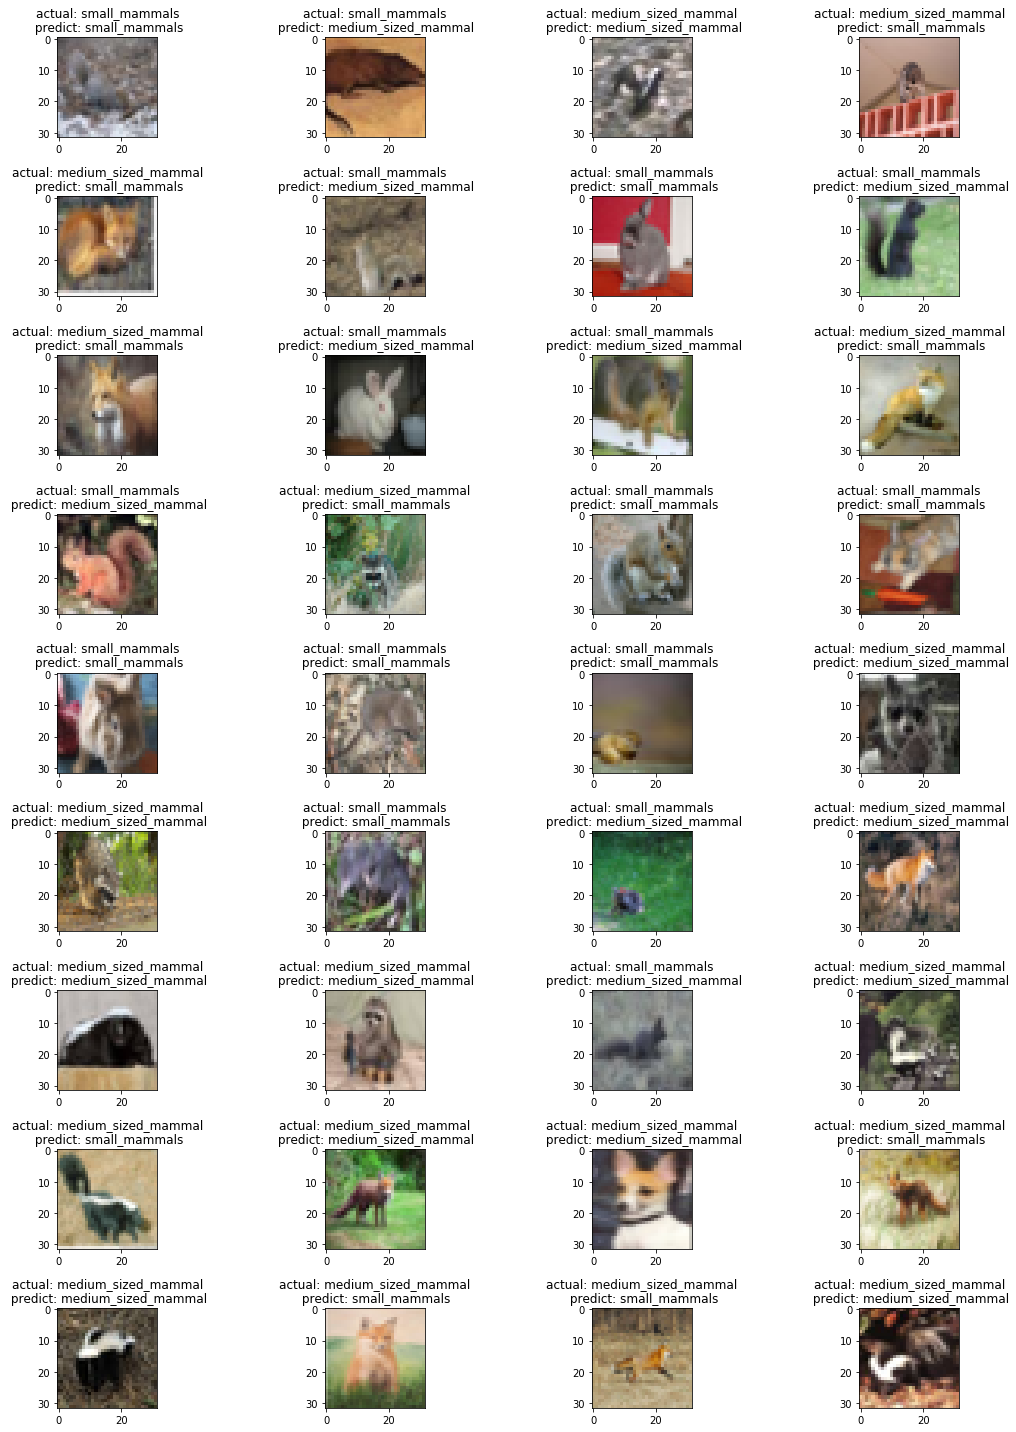

In [0]:
cifar_grid2(x_rest_mammals,y_rest_mammals_bin,indices,4,bag_pred)

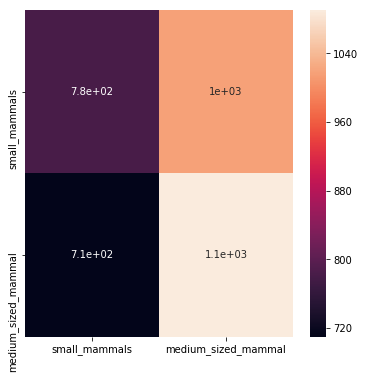

In [0]:
cm=confusion_matrix(y_rest_mammals_bin, bag_pred, labels=[0,1], sample_weight=None)
plt.figure(figsize = (6,6))
df_cm = pd.DataFrame(cm, index = [i for i in ['small_mammals','medium_sized_mammal']],
                  columns = [i for i in ['small_mammals','medium_sized_mammal']])

ax=sns.heatmap(df_cm, annot=True)

In [0]:
print(classification_report(y_rest_mammals_bin, bag_pred,target_names=['small_mammals','medium_sized_mammal']))

                     precision    recall  f1-score   support

      small_mammals       0.52      0.43      0.48      1800
medium_sized_mammal       0.52      0.61      0.56      1800

          micro avg       0.52      0.52      0.52      3600
          macro avg       0.52      0.52      0.52      3600
       weighted avg       0.52      0.52      0.52      3600



## **100 trials by the best peremeter**

In [0]:
bag_accuracy3=list()
bag_time3=list()
print("bagging") 
for i in range(0,100):
  start = time.time()
  bag1 = BaggingClassifier(n_estimators = 3, max_samples = 0.01, bootstrap = False, bootstrap_features = False)
  bag1.fit(x_train4_[i], y_train_bin4[i])
  bag1_pred=bag1.predict(x_test4_[i])
  print ("Accuracy ({}, {}): {}%".format(test_list2[i][0],test_list2[i][1] ,bag1.score(x_test4_[i], y_test_bin4[i])*100)) 
  end = time.time()
  print('{} seconds\n'.format(end - start))
  bag_accuracy3.append(bag1.score(x_test4_[i], y_test_bin4[i]))
  bag_time3.append(end-start)
  # choose 36 img randomly
  #indices = [np.random.choice(range(len(x_test3_[i]))) for j in range(36)]
  #cifar_grid1(x_test3_[i], y_test_bin3[i], indices,4,lr_pred)
print("average accuracy: {}%".format(np.mean(bag_accuracy3)*100))
print("average time: {} seconds".format(np.mean(bag_time3)))

bagging
Accuracy (['hamster', 'mouse'], ['fox', 'porcupine']): 50.041666666666664%
0.8124897480010986 seconds

Accuracy (['hamster', 'mouse'], ['fox', 'possum']): 54.666666666666664%
0.7724988460540771 seconds

Accuracy (['hamster', 'mouse'], ['fox', 'raccoon']): 58.70833333333333%
0.7522428035736084 seconds

Accuracy (['hamster', 'mouse'], ['fox', 'skunk']): 50.583333333333336%
0.7620813846588135 seconds

Accuracy (['hamster', 'mouse'], ['porcupine', 'possum']): 52.916666666666664%
0.7527353763580322 seconds

Accuracy (['hamster', 'mouse'], ['porcupine', 'raccoon']): 55.708333333333336%
0.753077507019043 seconds

Accuracy (['hamster', 'mouse'], ['porcupine', 'skunk']): 51.95833333333333%
0.7701106071472168 seconds

Accuracy (['hamster', 'mouse'], ['possum', 'raccoon']): 59.25%
0.7627575397491455 seconds

Accuracy (['hamster', 'mouse'], ['possum', 'skunk']): 43.0%
0.7549953460693359 seconds

Accuracy (['hamster', 'mouse'], ['raccoon', 'skunk']): 55.41666666666667%
0.77142333984375 seco

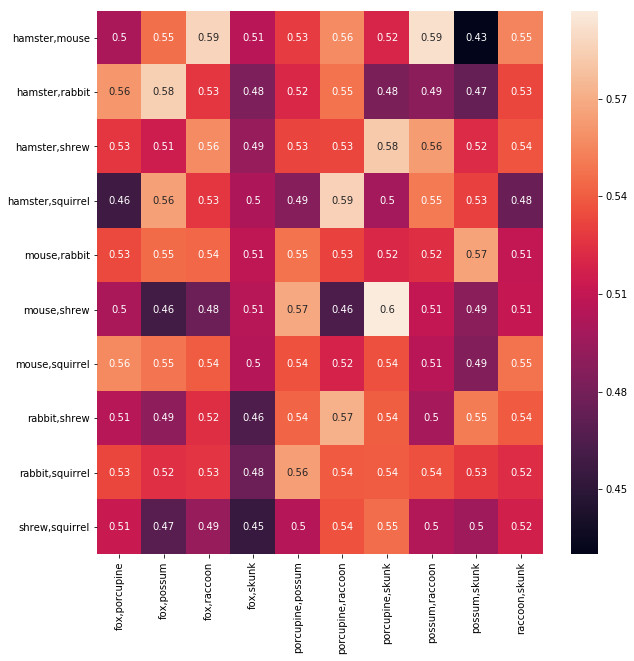

In [0]:
#cm=confusion_matrix(y_test_bin_1, bag_pred, labels=[0,1], sample_weight=None)
plt.figure(figsize = (10,10))
data=pd.DataFrame([bag_accuracy3[0:10],bag_accuracy3[10:20],bag_accuracy3[20:30],bag_accuracy3[30:40],bag_accuracy3[40:50],bag_accuracy3[50:60],bag_accuracy3[60:70],bag_accuracy3[70:80],bag_accuracy3[80:90],bag_accuracy3[90:100]],
                  index = [small_two[i][0]+','+small_two[i][1] for i in range(0,10)],
                  columns = [medium_two[i][0]+','+medium_two[i][1] for i in range(0,10)])


ax=sns.heatmap(data, annot=True)

In [0]:
pd.DataFrame(bag_accuracy3,columns=['Bagging missing 2 pairs']).describe()

,Bagging missing 2 pairs
count,100.000000
mean,0.523008
std,0.033473
min,0.430000
25%,0.501354
50%,0.526458
75%,0.545208
max,0.597083


#CNN (Qiao Liu)

In [0]:
# create list for train and test
x_train4=list()
x_test4=list()
y_train_bin4=list()
y_test_bin4=list()
test_list2=list()  
for i in range(0,10):
  for j in range(0,10):
    small=small_two[i]
    medium=medium_two[j]
    x_train_temp,x_test_temp,y_train_temp,y_test_temp=train_test_2(small,medium)
    x_train4.append(x_train_temp)
    x_test4.append(x_test_temp)
    y_train_bin4.append(y_train_temp)
    y_test_bin4.append(y_test_temp)
    test_list2.append([small,medium])  

Training set: [64 65 66 74 75 80]

Testing set: [34 36 50 63]
Training set: [63 65 66 74 75 80]

Testing set: [34 36 50 64]
Training set: [63 64 65 74 75 80]

Testing set: [34 36 50 66]
Training set: [63 64 65 66 74 80]

Testing set: [34 36 50 75]
Training set: [34 65 66 74 75 80]

Testing set: [36 50 63 64]
Training set: [34 64 65 74 75 80]

Testing set: [36 50 63 66]
Training set: [34 64 65 66 74 80]

Testing set: [36 50 63 75]
Training set: [34 63 65 74 75 80]

Testing set: [36 50 64 66]
Training set: [34 63 65 66 74 80]

Testing set: [36 50 64 75]
Training set: [34 63 64 65 74 80]

Testing set: [36 50 66 75]
Training set: [50 64 66 74 75 80]

Testing set: [34 36 63 65]
Training set: [50 63 66 74 75 80]

Testing set: [34 36 64 65]
Training set: [50 63 64 74 75 80]

Testing set: [34 36 65 66]
Training set: [50 63 64 66 74 80]

Testing set: [34 36 65 75]
Training set: [34 50 66 74 75 80]

Testing set: [36 63 64 65]
Training set: [34 50 64 74 75 80]

Testing set: [36 63 65 66]
Training

In [0]:
#connect to my google drive 
from google.colab import drive
from keras.models import load_model
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#Load saved model
model = load_model('/content/gdrive/My Drive/my_model4.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [0]:
#loop through all 100 pairs 
#the CNN will be initialized for each pair
for i in range(0,100):
  model = load_model('/content/gdrive/My Drive/my_model4.h5')
  lr = 0.0001
  opt = Adam(lr=lr, decay=1e-6)

  model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
  
  x_train = x_train4[i]
  x_test = x_test4[i]
  y_train_bin_c = to_categorical(y_train_bin4[i])
  y_test_bin_c = to_categorical(y_test_bin4[i])

  hist= model.fit(x_train, y_train_bin_c,validation_data=(x_test, y_test_bin_c), epochs=15)
  scores = model.evaluate(x_test, y_test_bin_c, verbose=0)
  
  print("trial ", i, " result: score: %.2f%%" % (scores[1]*100))

Train on 3600 samples, validate on 2400 samples
Epoch 1/15
 672/3600 [====>.........................] - ETA: 26s - loss: 0.4260 - acc: 0.8065

KeyboardInterrupt: ignored

In [0]:
#pick a set and run it again for further analysis
i = 19
model = load_model('/content/gdrive/My Drive/my_model4.h5')
lr = 0.0001
opt = Adam(lr=lr, decay=1e-6)

model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
  
x_train = x_train4[i]
x_test = x_test4[i]
y_train_bin_c = to_categorical(y_train_bin4[i])
y_test_bin_c = to_categorical(y_test_bin4[i])

hist= model.fit(x_train, y_train_bin_c,validation_data=(x_test, y_test_bin_c), epochs=20)
scores = model.evaluate(x_test, y_test_bin_c, verbose=0)
  
print("trial ", i, " result: score: %.2f%%" % (scores[1]*100))

Train on 3600 samples, validate on 2400 samples
Epoch 1/20
 928/3600 [======>.......................] - ETA: 24s - loss: 0.5247 - acc: 0.7284

KeyboardInterrupt: ignored

In [0]:
#function to plot model accuracy and loss
def plot_model_history(model_history):
   fig, axs = plt.subplots(1,2,figsize=(15,5))
   # summarize history for accuracy
   axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
   axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
   axs[0].set_title('Model Accuracy')
   axs[0].set_ylabel('Accuracy')
   axs[0].set_xlabel('Epoch')
   axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
   axs[0].legend(['train', 'test'], loc='best')
   # summarize history for loss
   axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
   axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
   axs[1].set_title('Model Loss')
   axs[1].set_ylabel('Loss')
   axs[1].set_xlabel('Epoch')
   axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
   axs[1].legend(['train', 'test'], loc='best')
   plt.show()

In [0]:
#plot training and testing loss
plot_model_history(hist)

In [0]:
y_predict = model.predict(x_test)
y_pred = np.argmax(y_predict, axis=1)

In [0]:
#Generate confusion matrix
from sklearn.metrics import confusion_matrix
import pandas as pd
confusion_df = pd.DataFrame(confusion_matrix(np.argmax(y_test_bin_c, axis=1), y_pred),
                           columns=["Predicted Class " + str(class_name) for class_name in ['Small Mammals', 'Medium sized Mammals']],
                           index = ['Class ' + str(class_name) for class_name in ['Small Mammals', 'Medium sized Mammals']])
print(confusion_df)

In [0]:
#Generate classification report
from sklearn.metrics import classification_report
target_names = ['Small Mammals', 'Medium sized Mammals']
print(classification_report(np.argmax(y_test_bin_c, axis = 1), y_pred, target_names=target_names))

In [0]:
#function for printing randomly selected images with labels and the prediction result
#Unmatched predictions will be colored red
def cifar_grid2(X,Y,inds,n_col,predictions):  #print out randomly selected images and their labels  
  N = len(inds)
  n_row = int(ceil(1.0*N/n_col))
  fig = plt.figure(figsize=(15, 20))
# align labels in the right order  #encode the target class
  clabels = ['small_mammals','medium_mammals']
  #print(type(clabels))
  for j in range(n_row):
    for k in range(n_col):
      i_inds = (j*n_col)+k
      i_data = inds[i_inds]
     
      if i_inds < N:
        rgb = X[[i_data,...]] 
        label =clabels[Y[i_data][0]]
        img = rgb.reshape(3,32,32).transpose([1, 2, 0])
        fig.add_subplot(n_row,n_col, i_inds+1)
        pred = clabels[predictions[i_data]]
        plt.imshow(img, interpolation='nearest')
        title_obj = plt.title("actual: {}\n predict: {}".format(label,pred))
        if label != pred:
          plt.setp(title_obj, color='r') 
        else:
          plt.setp(title_obj, color='k') 
         
  fig.set_tight_layout(True)

In [0]:
#Generate the random images vs. prediction
indices = [np.random.choice(range(len(x_rest_mammals))) for j in range(36)]
cifar_grid2(x_rest_mammals, y_rest_mammals_bin, indices,6,y_pred)